In [7]:
from pathlib import Path
import sys, os

# 1. cwd is project-root/examples
cwd = Path().resolve()
# 2. project-root is its parent
project_root = cwd.parent

# 3. add project_root to sys.path
sys.path.insert(0, str(project_root))

import fire
import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
# from torchmetrics.classification import MulticlassCalibrationError # Removed as requested


# These imports might not be strictly necessary for the PyTorch part,
# but are kept to match the original includes.
# from pytagi import HRCSoftmaxMetric, Utils, exponential_scheduler
from examples.torch_resnet_model import ResNet18 # Assuming this is your ResNet18 definition

torch.manual_seed(17)

# Constants for dataset normalization
NORMALIZATION_MEAN = [0.4914, 0.4822, 0.4465]
NORMALIZATION_STD = [0.2470, 0.2435, 0.2616]

In [8]:
def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images to shape (B*C*H*W,)
    batch_images = batch_images.reshape(-1)

    # Convert to numpy arrays
    batch_images = batch_images.numpy()
    batch_labels = batch_labels.numpy()

    return batch_images, batch_labels

def load_datasets(batch_size: int, framework: str = "torch"):
    """Load and transform CIFAR10 training and test datasets."""
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    train_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=True, download=True, transform=transform_train
    )
    test_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=False, download=True, transform=transform_test
    )

    # Note: custom_collate_fn is commented out in your original code,
    # so we'll leave it as default if you want standard PyTorch tensor output
    # If your model expects flattened numpy arrays, uncomment collate_fn and adjust model input.
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        # collate_fn=custom_collate_fn, # Commented out in your original, keeping consistent
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        # collate_fn=custom_collate_fn, # Commented out in your original, keeping consistent
    )

    return train_loader, test_loader

In [9]:
# Global dictionaries to store data for plot_class_uncertainty
images = {}
m_preds = {} # Will store probabilities (softmax output)

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_class_uncertainty(image_idx, images, m_preds, delta=0.3):
    """
    Plots CIFAR-10 images with class probabilities (no uncertainty bands).
    """
    img = images[image_idx]

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Denormalize if using standard CIFAR normalization
    mean = np.array(NORMALIZATION_MEAN).reshape(3, 1, 1)
    std = np.array(NORMALIZATION_STD).reshape(3, 1, 1)
    img_denormalized = img * std + mean
    img_denormalized = np.clip(img_denormalized, 0, 1)
    img_display = img_denormalized.transpose(1, 2, 0) # Convert to H, W, C for matplotlib imshow

    means = m_preds[image_idx] # These are probabilities from softmax

    classes = np.arange(10)

    fig, (ax_img, ax_prob) = plt.subplots(1, 2, figsize=(21, 6))

    # Image plot (CIFAR-10 specific)
    ax_img.imshow(img_display)
    ax_img.set_title(f'Img {image_idx}\nPred: {np.argmax(means)} | Σprob: {np.sum(means):.2f}')
    ax_img.axis('off')

    # Probability plot (mimicking Remax plot style but for standard probabilities without bands)
    for i in classes:
        ax_prob.scatter(i, means[i], color='c', marker='s', s=80,
                        zorder=3, edgecolor='k', linewidth=0.5)

    # Probability plot formatting
    ax_prob.set_xticks(classes)
    ax_prob.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
    ax_prob.set_xlim(-0.5, 9.5)
    ax_prob.grid(True, axis='y', linestyle=':')
    ax_prob.set_xlabel('Class')
    ax_prob.set_ylabel('Probability')
    ax_prob.set_title('Class Probabilities') # Title updated to reflect no uncertainty bands

    prob_legend = [
        Line2D([0], [0], marker='s', color='w', label='Class Probability',
              markerfacecolor='c', markersize=10),
    ]
    ax_prob.legend(handles=prob_legend, loc='upper right')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

The **Expected Calibration Error (ECE)** is a metric used to quantify the calibration of probabilistic models. It's calculated by partitioning predictions into $M$ bins based on their confidence, then summing the absolute difference between the accuracy and average confidence within each bin, weighted by the proportion of samples in that bin.

The formula for ECE is:

$$ ECE = \sum_{m=1}^{M} \frac{|B_m|}{N} |acc(B_m) - conf(B_m)| $$

Where:
- $M$ is the number of bins.
- $B_m$ is the set of samples whose prediction confidence falls into bin $m$.
- $|B_m|$ is the number of samples in bin $m$.
- $N$ is the total number of samples.
- $acc(B_m)$ is the accuracy of predictions in bin $m$.
- $conf(B_m)$ is the average confidence of predictions in bin $m$.

In [11]:
def compute_ece(probs, labels, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            acc_in_bin = np.mean(predictions[in_bin] == labels[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_conf_in_bin - acc_in_bin) * prop_in_bin

    return ece

The **Reliability Diagram** visualizes a model's **calibration** by comparing its predicted **confidence** to its **actual accuracy**.

* **X-axis (Confidence)**: Divided into bins based on prediction confidence.
* **Y-axis (Accuracy)**: Represents the true accuracy.
* **Blue Bars (Actual Accuracy)**: Show the proportion of correct predictions within each confidence bin.
* **Red Line (Average Confidence)**: This line represents the **average confidence level of all predictions that fall into a particular bin**. For instance, if you consider the bin for confidences between 0.7 and 0.8, the red line at the center of that bin will show the *average* confidence of all the predictions that the model made within that 0.7-0.8 range. It essentially tells you "On average, how confident was the model for the predictions in this bin?"
* **Gray Dashed Line (Perfect Calibration)**: The ideal line where confidence perfectly matches accuracy.
* **Numbers Above Bars (Bin Counts)**: Indicate the number of samples in each bin.

A **well-calibrated model** will have its blue bars and red line closely aligned with the gray dashed line. Deviations show over- or under-confidence.

In [12]:
def plot_reliability_diagram(probs, labels, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    correct = predictions == labels

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_accs = np.zeros(n_bins)
    bin_confs = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (confidences > bin_edges[i]) & (confidences <= bin_edges[i + 1])
        bin_counts[i] = np.sum(in_bin)
        if bin_counts[i] > 0:
            bin_accs[i] = np.mean(correct[in_bin])
            bin_confs[i] = np.mean(confidences[in_bin])

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.bar(bin_centers, bin_accs, width=0.8/n_bins, color='cornflowerblue', edgecolor='black', alpha=0.9, label='Actual Accuracy')
    ax.plot(bin_centers, bin_confs, 'o-', color='red', label='Avg Confidence', linewidth=2)
    ax.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')

    for i in range(n_bins):
        if bin_counts[i] > 0:
            ax.text(bin_centers[i], bin_accs[i] + 0.02, f'{int(bin_counts[i])}', ha='center', fontsize=9)

    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.set_title('Reliability Diagram (Confidence Calibration)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [13]:
def compute_multiclass_ece(probs, labels, n_bins=15):
    n_samples, n_classes = probs.shape

    confidences = probs.flatten()
    correct = np.zeros_like(confidences)

    one_hot = np.zeros_like(probs)
    one_hot[np.arange(n_samples), labels] = 1
    correct = one_hot.flatten()

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        if i == n_bins - 1:
            in_bin = (confidences >= bin_lower) & (confidences <= bin_upper)

        prop_in_bin = np.mean(in_bin)

        if np.any(in_bin):
            acc_in_bin = np.mean(correct[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_conf_in_bin - acc_in_bin) * prop_in_bin

    return ece

In [14]:
def plot_multiclass_reliability(probs, labels, n_bins=15):
    n_samples, n_classes = probs.shape
    confidences = probs.flatten()

    one_hot = np.zeros_like(probs)
    one_hot[np.arange(n_samples), labels] = 1
    correctness = one_hot.flatten()

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = (bin_lowers + bin_uppers) / 2

    bin_accs = []
    bin_confs = []
    bin_counts = []

    for bin_idx, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        if bin_idx == n_bins - 1:
            in_bin = (confidences >= bin_lower) & (confidences <= bin_upper)

        count_in_bin = np.sum(in_bin)
        bin_counts.append(count_in_bin)

        if count_in_bin > 0:
            bin_accs.append(np.mean(correctness[in_bin]))
            bin_confs.append(np.mean(confidences[in_bin]))
        else:
            bin_accs.append(0.0)
            bin_confs.append(0.0)

    plt.figure(figsize=(6, 6))
    plt.bar(bin_centers, bin_accs, width=0.8/n_bins, color='skyblue', edgecolor='black', label='Actual Accuracy')
    plt.plot(bin_centers, bin_confs, 'o-', color='red', label='Avg Confidence', linewidth=2)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')

    for i in range(n_bins):
        if bin_counts[i] > 0:
            plt.text(bin_centers[i], bin_accs[i] + 0.02, str(bin_counts[i]), ha='center', fontsize=8)

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Multiclass Reliability Diagram (All Class Predictions)')
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [15]:
def evaluate_and_calibrate(model_path: str, batch_size: int = 128, device: str = "cuda"):
    torch_device = torch.device(device)
    if "cuda" in device and not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. Please check your installation.")

    train_loader, test_loader = load_datasets(batch_size, "torch")

    model = ResNet18()
    model.load_state_dict(torch.load(model_path, map_location=torch_device, weights_only=True))
    model.to(torch_device)
    model.eval()

    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    all_probs_list = []
    all_labels_list = []

    global images, m_preds # v_preds removed
    images = {}
    m_preds = {}
    current_image_idx = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            if not isinstance(target, torch.Tensor):
                target = torch.tensor(target, dtype=torch.long)

            if data.dim() == 1:
                current_batch_size = target.shape[0]
                data = data.reshape(current_batch_size, 32, 32, 3)

            if data.dim() == 4 and data.shape[-1] == 3:
                data = data.permute(0, 3, 1, 2)

            data = data.to(torch_device)
            target = target.to(torch_device)

            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            probs = torch.softmax(output, dim=1)
            preds = probs.argmax(dim=1)
            correct += preds.eq(target).sum().item()
            total_samples += target.size(0)

            all_probs_list.append(probs)
            all_labels_list.append(target)

            # Populate global dictionaries for plot_class_uncertainty
            for i in range(data.shape[0]):
                images[current_image_idx] = data[i].cpu().numpy()
                m_preds[current_image_idx] = probs[i].cpu().numpy()
                current_image_idx += 1

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total_samples * 100

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

    final_probs_np = torch.cat(all_probs_list, dim=0).cpu().numpy()
    final_labels_np = torch.cat(all_labels_list, dim=0).cpu().numpy()

    print("\n--- Calibration Results ---")

    ece_score = compute_ece(final_probs_np, final_labels_np)
    print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

    plot_reliability_diagram(final_probs_np, final_labels_np, n_bins=15)

    ece_mc = compute_multiclass_ece(final_probs_np, final_labels_np, n_bins=15)
    print(f"Multiclass ECE: {ece_mc:.4f}")

    plot_multiclass_reliability(final_probs_np, final_labels_np, n_bins=15)

Files already downloaded and verified
Files already downloaded and verified


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 19.20it/s]



Test Loss: 0.3491
Test Accuracy: 91.02%

--- Calibration Results ---
Expected Calibration Error (ECE): 0.0479


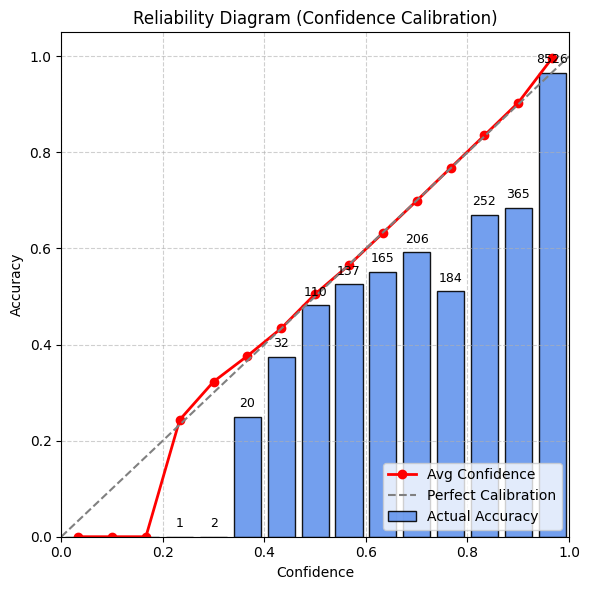

Multiclass ECE: 0.0099


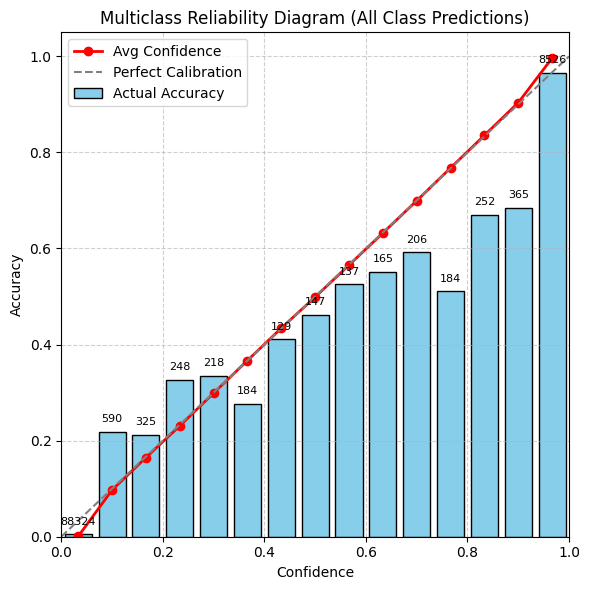

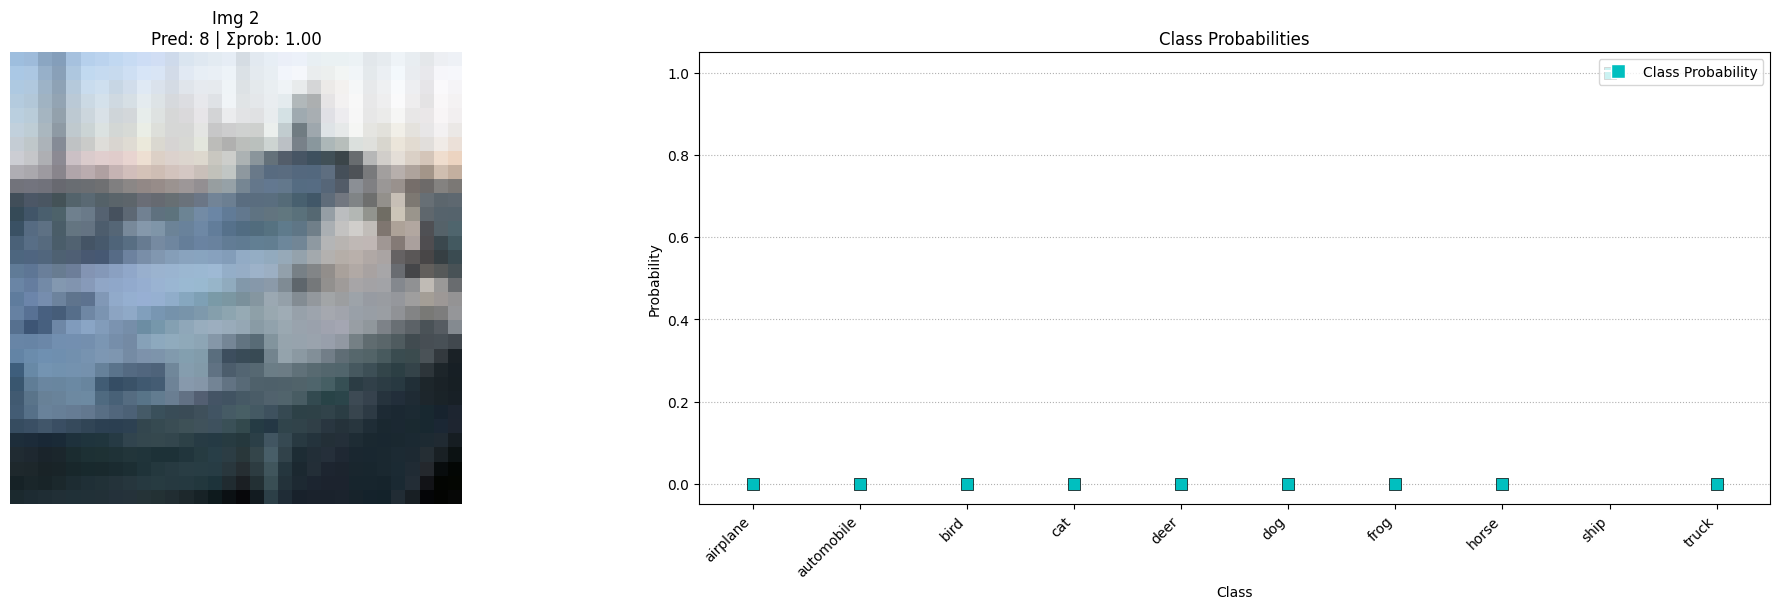

In [16]:
model_path = "../models_bin/cifar_torch_resnet18.bin"

evaluate_and_calibrate(model_path, batch_size=128, device="cuda")

plot_class_uncertainty(2, images, m_preds)